In [11]:
from predict import getMask
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
import style.utils as utils
from style.CLIPstyler import getStyleImg
from torchvision import transforms, models
import torch.nn.functional as F
import clip
from style.template import imagenet_templates
from PIL import Image
import random
import itertools


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_path = "./testimg/ship.jpg"
config_path = "./config/refcoco+/test.yaml"
model_pth = "./best_model.pth"

sent = "a white boat with blue sails on the sea"
sent = "the a white with sails on blue"

In [13]:
def getMaskImg(img,config_path,model_pth,sent=None):
    img_style1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_style2 = img_style1/255.0
    img_style3 = np.transpose(img_style2, (2,0,1))
    img_style4 = torch.Tensor(img_style3)
    img_style = torch.unsqueeze(img_style4, 0)

    mask0 = getMask(img,sent,config_path,model_pth)
    mask1 = np.stack((mask0, mask0,mask0), axis=2)
    mask_img = np.array(mask1*255, dtype=np.uint8)
    return mask_img

def load_image(img,mode="PLT"):
    if mode == "CV":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
                        transforms.ToTensor(),
                        ])   
    image = transform(img)[:3, :, :].unsqueeze(0)
    return image

def squeeze_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze(0)
    image = torch.Tensor(image)
    return image

def getCropsInMask(img,mask,size,batch):
    pot_crop = []
    cropper = transforms.RandomCrop(size)
    while len(pot_crop)<batch  :
        (i, j, h, w) = cropper.get_params(squeeze_convert(mask), (size, size))
        mask_crop = transforms.functional.crop(mask, i, j, h, w)
        img_crop = transforms.functional.crop(img, i, j, h, w)
        if int(mask_crop[0].sum())/(3*size*size) >= 0.9:
            if len(pot_crop)<batch :
                pot_crop.append(img_crop)
    return pot_crop

def clip_normalize2(image,device):
    image = F.interpolate(image,size=224,mode='bicubic')
    return image

def getCrops(img,size,batch):
    crops = []
    cropper = transforms.RandomCrop(size)
    
    #获取足够数量的物体裁剪照片
    while len(crops)<batch  :
        (i, j, h, w) = cropper.get_params(squeeze_convert(img), (size, size))
        img_crop = transforms.functional.crop(img, i, j, h, w)
        crops.append(img_crop)
    return crops

def getLoss(text_feature,img_feature):
    return 1-torch.cosine_similarity(text_feature, img_feature)

def getClipImgFeature(image,clip_model):
    image = F.interpolate(image,size=224,mode='bicubic')
    image = clip_model.encode_image(image.to(device))
    image /= image.norm(dim=-1, keepdim=True)
    return image

def img_normalize(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image

def getVggFeature(image,device,VGG):
    return utils.get_features(img_normalize(image), VGG)

def getVggFeatureLossMES(image,target):
    content_loss = 0
    content_loss += torch.mean((target['conv4_2'] - image['conv4_2']) ** 2)
    content_loss += torch.mean((target['conv5_2'] - image['conv5_2']) ** 2)
    
    return content_loss


In [14]:
clip_model, _ = clip.load('ViT-B/32', device, jit=False)
VGG = models.vgg19(pretrained=True).features
VGG.to(device)
for parameter in VGG.parameters():
    parameter.requires_grad_(False)

In [15]:
img = cv2.imread(img_path)
mask = getMaskImg(img,config_path,model_pth,sent)

img = load_image(img,mode="CV")
mask = load_image(mask)


plt.imshow(utils.im_convert2(img))
plt.show()
plt.imshow(utils.im_convert2(mask))
plt.show()

2022-11-04 23:16:24.798 | INFO     | model:build_segmenter:46 - Backbone with decay=325, Head=127
2022-11-04 23:16:36.907 | ERROR    | __main__:getMaskImg:8 - An error has been caught in function 'getMaskImg', process 'MainProcess' (42752), thread 'MainThread' (34476):
Traceback (most recent call last):

  File "c:\setup\python\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
           │         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
           │         └ <code object <module> at 0x000002A41B6E3BE0, file "c:\setup\python\lib\site-packages\ipykernel_launcher.py", line 1>
           └ <function _run_code at 0x000002A41B81E310>

  File "c:\setup\python\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipy

AxisError: axis 2 is out of bounds for array of dimension 1

In [9]:
images = getCropsInMask(img,mask,64,64)
# for image in images:
#     plt.imshow(utils.im_convert2(image))
#     plt.show()

In [12]:
images_crops = torch.cat(images,dim=0)
images_crops_clipFeatures = clip_model.encode_image(clip_normalize2(images_crops.to(device),device))
print(images_crops_clipFeatures)

tensor([[-0.0759,  0.2910, -0.3757,  ...,  1.3906, -0.1970,  0.1267],
        [-0.1650,  0.3081, -0.3889,  ...,  0.8486, -0.3501,  0.1849],
        [ 0.1606,  0.1349, -0.5796,  ...,  1.3203, -0.0412,  0.0201],
        ...,
        [-0.1102, -0.1969, -0.3896,  ...,  1.1270,  0.0320, -0.0622],
        [-0.0519,  0.3628, -0.5957,  ...,  1.2363,  0.0219,  0.2062],
        [-0.1575,  0.0603, -0.2651,  ...,  1.3574,  0.1515, -0.0088]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward>)


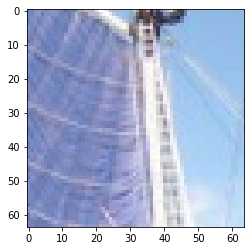

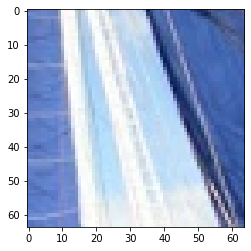

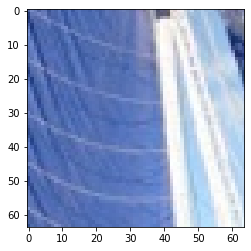

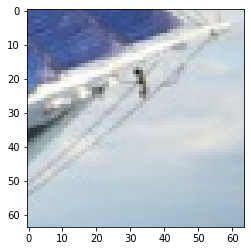

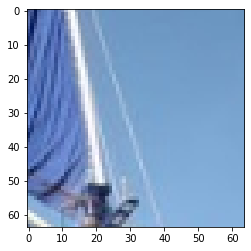

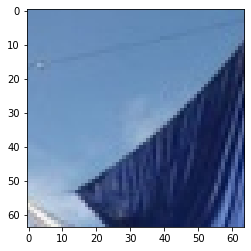

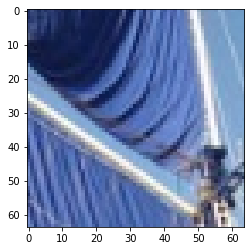

In [44]:
for target in getCrops(img,64,64):
    target_feature = getClipImgFeature(target,clip_model)
    res = getLoss(target_feature,images_crops_clipFeatures)
    num = torch.numel(res[res<0.07])
    if num >12:
        plt.imshow(utils.im_convert2(target))
        plt.show()

In [26]:
temp = torch.tensor(19.1693).to(device)
float(temp)

19.169300079345703

In [46]:
# for image in images:
#     plt.imshow(utils.im_convert2(image))
#     plt.show()

In [38]:
image = images[0]
image_feature = getVggFeature(image.to(device),VGG)
image_feature = image_feature["conv5_2"]
img_loss = getLoss(image_feature,image_feature)
img_loss.sum() > -1

tensor(True, device='cuda:0')

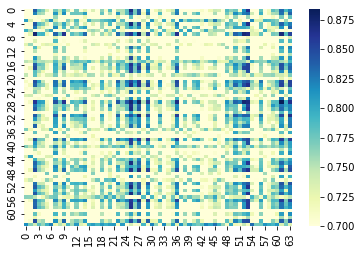

In [94]:
def get_images_masks(image_crops,image,mask,size,vgg):
    """
    info:   
    input:  image_crops([list:batch]),mask[1],target[1] => 
    output: images([list]) => 黑里面的(>=0.2batch)
    """
    import math,random,time
    random.seed(int(time.time()))
    rate = 1/math.exp(200)
    counter = 0

    cropper = transforms.RandomCrop(size)       
        
    image_vgg_feature_list = []
    out_list = []
    for _image in images:
        image_vgg_feature_list.append(getVggFeature(_image.to(device),device,vgg))
    while random.uniform(0,math.exp(counter))*rate < 0.5 and len(out_list) < 0.2*len(image_crops):
        (i, j, h, w) = cropper.get_params(squeeze_convert(image), (size, size))
        print(i,j,h,w)
        img_crop = transforms.functional.crop(img, i, j, h, w)
        mask_crop = transforms.functional.crop(mask, i, j, h, w)
        total_count = 0
        img_vgg_feature = getVggFeature(img_crop.to(device),device,VGG)['conv5_2']
        for ivf in image_vgg_feature_list:
            # vgg_loss = float(getVggFeatureLossMES(ivf,target_vgg_feature))
            vgg_loss = getLoss(ivf['conv5_2'],img_vgg_feature).sum()
            # print(vgg_loss)
            if vgg_loss < 9:
                total_count += 1
        if int(mask_crop[0].sum())/(3*size*size) > 0.1:
            counter += 1
        elif total_count > 0.2*len(image_crops):
            print(i,j,h,w)
            out_list.append(img_crop)
            counter+=1
        else:
            counter+=1
    return out_list

# imgs_ = get_images_masks(getCropsInMask(img,mask,64,64),img,mask,64,VGG)
# print(img.shape)
# for img_ in imgs_:
#     plt.imshow(utils.im_convert2(img_))
#     plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

image_vgg_feature_list = []

heat_map = [[0 for _ in range(64)] for _ in range(64)]

for image in images:
    image_vgg_feature_list.append(getVggFeature(image.to(device),device,VGG))
for target_index_,target in enumerate(getCrops(img,64,64)):
    target_vgg_feature = getVggFeature(target.to(device),device,VGG)['conv5_2']
    total_count = 0
    for ivf_index_, ivf in enumerate(image_vgg_feature_list):
        # vgg_loss = float(getVggFeatureLossMES(ivf,target_vgg_feature))
        vgg_loss = getLoss(ivf['conv5_2'],target_vgg_feature).sum()
        heat_map[target_index_][ivf_index_] = float(vgg_loss)/16
        # print(vgg_loss)
        if vgg_loss < 9:
            total_count += 1
    # if total_count > 12:
    #     plt.imshow(utils.im_convert2(target))
    #     plt.show()

sns.heatmap(heat_map,cmap="YlGnBu",vmin=0.7)
plt.show()